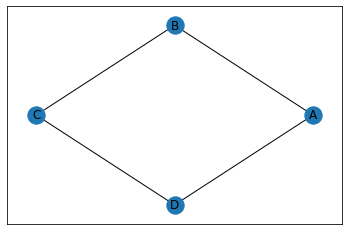

In [3]:
import sympy as sp 
import networkx as nx
import numpy as np
from matplotlib import pyplot as plt
# from utils import print_function

nodes = sp.symbols('A:D')
G = nx.cycle_graph(nodes)
pos = nx.circular_layout(G)
nx.draw_networkx(G, pos)




In [22]:
from utils import print_function, showlatex
sp.init_printing()
p = sp.Function('\\tilde p')(*nodes)
import inspect


TypeError: unsupported callable